In [1]:
# !if [ -f demo.tar ]; then rm demo.tar; fi
# !if [ -d test_data ]; then rm -rf test_data; fi
# !wget -q https://github.com/AI4EPS/GaMMA/releases/download/test_data/demo.tar
# !tar -xf demo.tar

In [2]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm

In [3]:
data_path = "test_data/ridgecrest/"
stations = pd.read_csv(os.path.join(data_path, "stations.csv"))
stations["depth_km"] = - stations["elevation_m"] / 1000
stations.iloc[:3]

,station_id,longitude,latitude,elevation_m,depth_km
0,CI.CCC..BH,-117.365,35.525,670.0,-0.67
1,CI.CCC..HH,-117.365,35.525,670.0,-0.67
2,CI.CCC..HN,-117.365,35.525,670.0,-0.67


In [4]:
## Automatic region; you can also specify a region
lon0 = stations["longitude"].median()
lat0 = stations["latitude"].median()

## projection to km
# proj = Proj(f"+proj=sterea +lon_0={lon0} +lat_0={lat0} +k=0.9996 +x_0=0 +y_0=0 +ellps=WGS84 +units=km +no_defs")
proj = Proj(f"+proj=sterea +lon_0={lon0} +lat_0={lat0}  +units=km")
stations[["x_km", "y_km"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
stations["z_km"] = stations["elevation_m"].apply(lambda x: -x/1e3)

xmin = stations["x_km"].min()
xmax = stations["x_km"].max()
ymin = stations["y_km"].min()
ymax = stations["y_km"].max()
x0 = (xmin + xmax) / 2
y0 = (ymin + ymax) / 2

## set up the config; you can also specify the region manually
config = {}
config["xlim_km"] = (2 * xmin - x0, 2 * xmax - x0)
config["ylim_km"] = (2 * ymin - y0, 2 * ymax - y0)
config["zlim_km"] = (stations["z_km"].min(), 30)

config["bfgs_bounds"] = (
    (config["xlim_km"][0] - 1, config["xlim_km"][1] + 1),  # x
    (config["ylim_km"][0] - 1, config["ylim_km"][1] + 1),  # y
    (config["zlim_km"][0], config["zlim_km"][1] + 1),  # z
    (None, None),  # t
)


Text(0.5, 1.0, 'Stations')

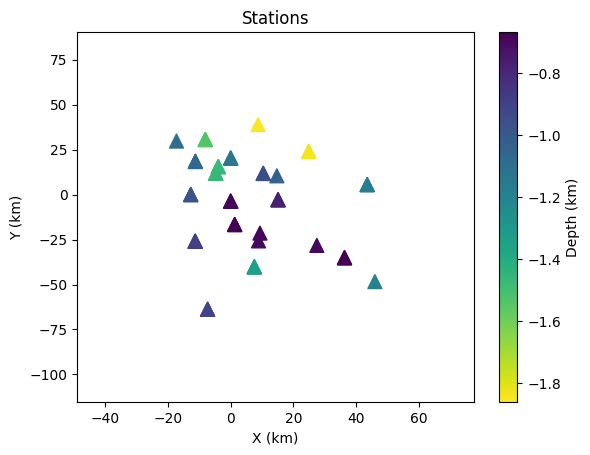

In [5]:
plt.figure()
plt.scatter(stations["x_km"], stations["y_km"], c=stations["depth_km"], cmap="viridis_r", s=100, marker="^")
plt.colorbar(label="Depth (km)")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.xlim(config["xlim_km"])
plt.ylim(config["ylim_km"])
plt.title("Stations")

In [6]:
data_path = "results/ridgecrest/"
picks = pd.read_csv(os.path.join(data_path, "gamma_picks.csv"), parse_dates=["phase_time"])
events = pd.read_csv(os.path.join(data_path, "gamma_events.csv"), parse_dates=["time"])


In [7]:
picks.iloc[:3]

,station_id,phase_time,phase_score,phase_amplitude,phase_type,event_index,gamma_score
0,CI.CCC..BH,2019-07-04 22:00:06.084,0.939738,0.000017,P,261,0.249849
1,CI.CCC..BH,2019-07-04 22:00:31.934,0.953992,0.000006,P,263,0.249849
2,CI.CCC..BH,2019-07-04 22:00:38.834,0.837302,0.000006,P,264,0.249849


In [8]:
events.iloc[:3]

,time,magnitude,sigma_time,sigma_amp,cov_time_amp,gamma_score,num_picks,num_p_picks,num_s_picks,event_index,x(km),y(km),z(km),longitude,latitude,depth_km
0,2019-07-04 19:25:32.811,1.344,0.572,0.353,0.070,26.854,25,13,12,30,25.488,-12.236,6.337,-117.483,35.731,6.337
1,2019-07-04 19:25:43.605,1.635,0.441,0.291,0.026,74.435,75,38,37,32,21.956,-12.790,9.472,-117.522,35.726,9.472
2,2019-07-04 18:32:07.863,2.012,0.831,0.305,0.055,59.810,57,30,27,76,18.159,-22.810,11.818,-117.565,35.636,11.818


In [9]:
from adloc.eikonal2d import eikonal_solve
from adloc.sacloc2d import ADLoc
from adloc import RANSACRegressor
import numpy as np

In [10]:
def init_eikonal2d(config):

    rlim = [0, np.sqrt((config["xlim_km"][1] - config["xlim_km"][0]) ** 2 + (config["ylim_km"][1] - config["ylim_km"][0]) ** 2)]
    zlim = config["zlim_km"]
    h = config["h"]

    rgrid = np.arange(rlim[0], rlim[1] + h, h)
    zgrid = np.arange(zlim[0], zlim[1] + h, h)
    nr = len(rgrid)
    nz = len(zgrid)

    vel = config["vel"]
    zz, vp, vs = vel["Z"], vel["P"], vel["S"]
    vp1d = np.interp(zgrid, zz, vp)
    vs1d = np.interp(zgrid, zz, vs)
    vp = np.tile(vp1d, (nr, 1))
    vs = np.tile(vs1d, (nr, 1))

    up = 1000 * np.ones((nr, nz))
    up[0, 0] = 0.0

    up = eikonal_solve(up, vp, h)
    grad_up = np.gradient(up, h, edge_order=2)
    up = up.ravel()
    grad_up = [x.ravel() for x in grad_up]

    us = 1000 * np.ones((nr, nz))
    us[0, 0] = 0.0

    us = eikonal_solve(us, vs, h)
    grad_us = np.gradient(us, h, edge_order=2)
    us = us.ravel()
    grad_us = [x.ravel() for x in grad_us]

    config.update(
        {
            "up": up,
            "us": us,
            "grad_up": grad_up,
            "grad_us": grad_us,
            "rgrid": rgrid,
            "zgrid": zgrid,
            "nr": nr,
            "nz": nz,
            "h": h
        }
    )

    return config

In [11]:
## Eikonal for 1D velocity model
zz = [0.0, 5.5, 16.0, 32.0]
vp = [5.5, 5.5,  6.7,  7.8]
vp_vs_ratio = 1.73
vs = [v / vp_vs_ratio for v in vp]
h = 0.3
vel = {"Z": zz, "P": vp, "S": vs}
config["eikonal"] = {"vel": vel, "h": h, "xlim_km": config["xlim_km"], "ylim_km": config["ylim_km"], "zlim_km": config["zlim_km"]}
config["eikonal"] = init_eikonal2d(config["eikonal"])


Eikonal Solver: 
Iter 0, error = 999.945
Iter 1, error = 0.000
Time: 3.340
Eikonal Solver: 
Iter 0, error = 999.906
Iter 1, error = 0.000
Time: 0.084


In [12]:
# %%
stations["idx_sta"] = stations.index  # reindex in case the index does not start from 0 or is not continuous

events["idx_eve"] = events.index  # reindex in case the index does not start from 0 or is not continuous

picks = picks.merge(events[["event_index", "idx_eve"]], on="event_index")

picks = picks.merge(stations[["station_id", "idx_sta"]], on="station_id")

In [13]:
# %% backup old events
events_old = events.copy()
events_old[["x_km", "y_km"]] = events_old.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
events_old["z_km"] = events["depth_km"]

In [14]:
## Location using ADLoc
MIN_ADLOC_SCORE = 0.9
estimator = ADLoc(config, stations=stations[["x_km", "y_km", "z_km"]].values, eikonal=config["eikonal"])
event_init = np.array([[np.mean(config["xlim_km"]), np.mean(config["ylim_km"]), np.mean(config["zlim_km"]), 0.0]])
picks_mask = pd.DataFrame(index=picks.index, columns=["mask"])
picks_error = pd.DataFrame(index=picks.index, columns=["residual_s"])
for event_index, picks_by_event in tqdm(picks.groupby("idx_eve")):

    X = picks_by_event.merge(
        stations[["x_km", "y_km", "z_km", "station_id"]],
        on="station_id",
    )
    t0 = X["phase_time"].min()
    X.rename(columns={"phase_type": "type", "phase_time": "t_s"}, inplace=True)
    X["t_s"] = (X["t_s"] - t0).dt.total_seconds()
    X = X[["x_km", "y_km", "z_km", "t_s", "type", "idx_sta"]]
    mapping_int = {"P": 0, "S": 1}
    X["type"] = X["type"].apply(lambda x: mapping_int[x.upper()])

    estimator.set_params(**{"events": event_init})
    ## Location using ADLoc
    # estimator.fit(X[["idx_sta", "type"]].values, y=X["t_s"].values)

    ## Location using RANSAC
    reg = RANSACRegressor(
        estimator=estimator,
        random_state=0,
        min_samples=4,
        residual_threshold=1.0,
    )
    reg.fit(X[["idx_sta", "type"]].values, X["t_s"].values)
    estimator = reg.estimator_
    mask = reg.inlier_mask_
    picks_mask.loc[picks_by_event.index, "mask"] = mask

    ## Predict travel time
    score = estimator.score(X[["idx_sta", "type"]].values, y=X["t_s"].values)
    tt = estimator.predict(X[["idx_sta", "type"]].values)
    mean_residual_s = np.mean(np.abs(X["t_s"].values - tt))
    picks_error.loc[picks_by_event.index, "residual_s"] = X["t_s"].values - tt

    if score > MIN_ADLOC_SCORE:
        x,y,z,t = xyz = estimator.events[0]
        events.loc[event_index, ["x_km", "y_km", "z_km", "time"]] = x, y, z, t0 + pd.Timedelta(t, unit="s")
        events.loc[event_index, "adloc_score"] = score
        events.loc[event_index, "adloc_residual_s"] = mean_residual_s
    else:
        # delete the event
        events.loc[event_index, ["x_km", "y_km", "z_km", "time"]] = np.nan, np.nan, np.nan, np.nan
        picks_mask.loc[picks_by_event.index, "mask"] = False

## Filter nan events
events = events.dropna(subset=["x_km", "y_km", "z_km", "time"])

100%|██████████| 1376/1376 [03:09<00:00,  7.28it/s]


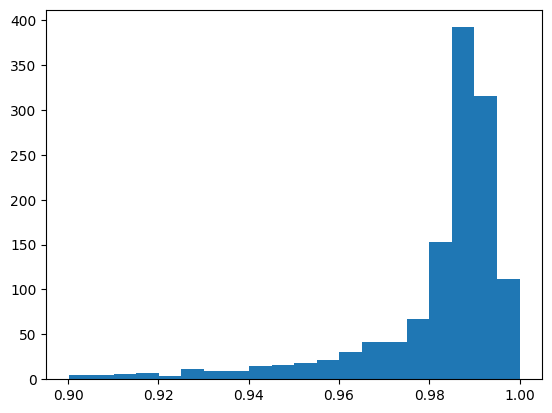

In [15]:
plt.figure()
plt.hist(events["adloc_score"], bins=20) 
plt.show()

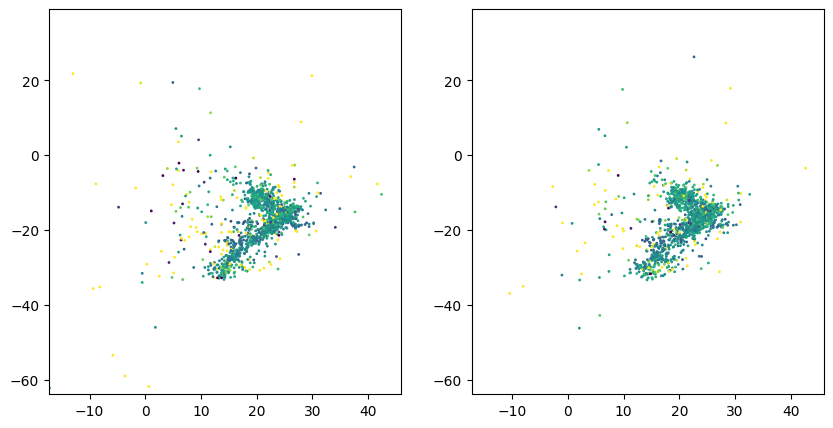

In [17]:
plt.figure(figsize=(10, 5))
vmin = min(events["depth_km"].min(), events_old["depth_km"].min())
vmax = max(events["depth_km"].max(), events_old["depth_km"].max())

plt.subplot(121)
plt.scatter(events_old["x_km"], events_old["y_km"], c=events_old["depth_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.subplot(122)
plt.scatter(events["x_km"], events["y_km"], c=events["depth_km"], cmap="viridis_r", s=1, marker="o", vmin=vmin, vmax=vmax)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()